# Homing path properties associated with performance

Are the homing paths with large error (inaccurate) different from the precise homing paths.

If the mouse is making a mistake, maybe the behavior is different. 
For instance, it could be that the running speed is lower when the mouse is uncertain about its running direction.
It could also be that different navigation strategies are used when the mouse has lost track of where it is.
Or it could be that the animal lost its focus and started to run randomly.

Confidently wrong Vs Uncentainly wrong

Here we only focus on the homing path itself, from the moment the animal left the lever until it reached periphery.


In [2]:
import pandas as pd
import numpy as np
import os.path
import pickle
from autopipy.project import Project

In [3]:
projectName="autopi_behavior_2021"
dataPath="/adata/projects/autopi_behavior_2021"
dlcModelPath="/adata/models"
myProject = Project(name=projectName,dataPath=dataPath,dlcModelPath=dlcModelPath)
fn=myProject.dataPath+"/testing_sessions"
print("Reading " + fn)
sessionNamesTesting = pd.read_csv(fn) # this will be a pandas dataframe
myProject.createSessionList(sessionNameList=sessionNamesTesting.sessionName.to_list())
print("We have {} recording sessions".format(len(myProject.sessionList)))

Project name: autopi_behavior_2021
dataPath: /adata/projects/autopi_behavior_2021
dlcModelPath: /adata/models
Reading /adata/projects/autopi_behavior_2021/testing_sessions
We have 67 recording sessions


In [4]:
# load the training DataFrame
fn =  myProject.dataPath+"/results/trialsTrainSet.csv"
df = pd.read_csv(fn)
print("Number of trials: {}".format(len(df)))

# load the speed profile (dict of np.arrays)
fn =  myProject.dataPath+"/results/sProfileTrainSet.pkl"
print("loading pickle {}".format(fn))
sProfile = pickle.load(open(fn, "rb" ) )
print("Number of trilas: {}".format(sProfile["searchTotal"].shape[0]))



Number of trials: 3616
loading pickle /adata/projects/autopi_behavior_2021/results/sProfileTrainSet.pkl
Number of trilas: 3616


In [5]:
# remove invalid trials
boolIndices = df.valid
print("Number of valid trials: {}".format(sum(boolIndices)))

df = df[boolIndices]
for k in sProfile:
    sProfile[k] = sProfile[k][boolIndices,:]

if sProfile["searchTotal"].shape[0] != len(df):
    print("Problem with the length of sProfile and df")

Number of valid trials: 3574


Select a session to display examples of precise and imprecise homing

In [7]:
ses = myProject.sessionList[2]
ses.extractTrialFeatures()
# get accurate and inaccurate homing to periphery
lc="dark"
dfOneSes = df[(df.sessionName==ses.name) & (df.light == lc)]
preciseIndices = dfOneSes["angularErrorHomingPeri"].rank().sort_values().index[0:6]
impreciseIndices = dfOneSes["angularErrorHomingPeri"].rank().sort_values().index[-6:]
# dictionary of df
trialsOnDisplay = {"precise": dfOneSes.loc[preciseIndices,:], 
                   "imprecise": dfOneSes.loc[impreciseIndices,:]}

mn4656-02102019-1702 trial segmentation
problem with the door alternation
Problem with index 742
Removing the second of two door closings (index :742)
Problem with index 871
Removing the second of two door closings (index :871)
Number of trials : 70
mn4656-02102019-1702, video len: 108555, video-log:0, first frame: 0, max log gap: nan, mean time diff: 0.0335, max time diff: 0.0371, num problem diff: 0, frame rate: 29.8
Lenght of mouseLeverPosi: 108555
Lenght of videoLog: 108555
mn4656-02102019-1702_25, self.startTime was adjusted by -0.1 s
mn4656-02102019-1702_26, homingPeriPose path has a length < 2
mn4656-02102019-1702_26, homingPeriNoLeverPose path has a length < 2
homingPeri :pPose has a length of 1
homingPeri :empty NavPath created
homingPeriNoLever :pPose has a length of 0
homingPeriNoLever :empty NavPath created
mn4656-02102019-1702_27, homingPeriNoLeverPose path has a length < 2
homingPeriNoLever :pPose has a length of 0
homingPeriNoLever :empty NavPath created
mn4656-02102019-

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import matplotlib.gridspec as gridspec
plt.style.use("seaborn")


In [9]:
t = ses.getTrial(2)

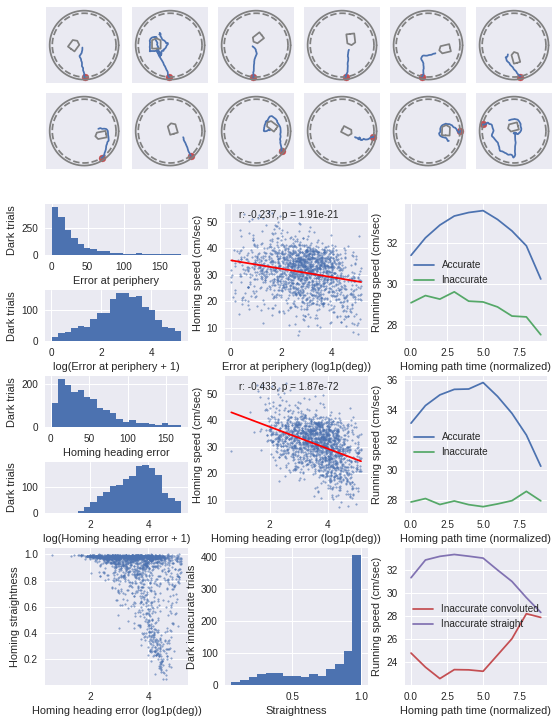

In [104]:
fig = plt.figure(figsize=(9,12))
gs = gridspec.GridSpec(8,6) # create a 8 x 6 grid for plotting
fig.tight_layout()
plt.subplots_adjust(wspace=0.7,hspace=0.7)
lc = "dark"


# to plot the arena circle
arena=np.arange(start=0,stop=2*np.pi,step=0.02)
arenaRadiusProportionToPeri=0.925
arenaRadius = 40
 
# trial examples from a single session
for i,k in enumerate(trialsOnDisplay):
    for j,t in enumerate(trialsOnDisplay[k].trialNo):
        ax = plt.subplot(gs[i, j]) # get a subplot
        ax.set_aspect('equal', adjustable='box')
      
        
        # arena
        ax.plot(np.cos(arena)*arenaRadius,np.sin(arena)*arenaRadius,label="Arena",color="gray")
        ax.plot(np.cos(arena)*arenaRadius*arenaRadiusProportionToPeri,np.sin(arena)*arenaRadius*arenaRadiusProportionToPeri,label="Periphery",color="gray",linestyle='dashed')
        t = ses.getTrial(t)
        # path
        ax.plot(t.pathD["homingPeriNoLever"].pPose[:,0],
                t.pathD["homingPeriNoLever"].pPose[:,1])
        # peripoint
        ax.scatter(t.peripheryAfterFirstLeverPressCoordCm[0],
                    t.peripheryAfterFirstLeverPressCoordCm[1],color=sns.color_palette()[2])
        # lever
        ax.plot(t.leverCm.pointsPlot[:,0],t.leverCm.pointsPlot[:,1], color = "gray")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # make the figure bigger
        pos1 = ax.get_position() # get the original position 
        pos2 = [pos1.x0 - 0.006*j, pos1.y0,  pos1.width * 1.5, pos1.height * 1.5] 
        ax.set_position(pos2) # set a new position

######################################
# distribution of error at periphery##
######################################
ax = plt.subplot(gs[2:3, 0:2], ) # get a subplot

maxSpeed=55
df1 = df[["timeLever","angularErrorHomingPeri","homingPeriNoLever_meanSpeed","homingPeriNoLever_length","homingPeriNoLever_duration","homingPeri_meanVectorLengthOri","light" ]]
x = df1["angularErrorHomingPeri"][(df1.light==lc) & (df1.homingPeriNoLever_meanSpeed < maxSpeed)]
y = df1["homingPeriNoLever_meanSpeed"][(df1.light==lc) & (df1.homingPeriNoLever_meanSpeed < maxSpeed)]
ax.hist(x, bins=20)
ax.set_xlabel("Error at periphery")
ax.set_ylabel("Dark trials")

# log1p of distribution
ax = plt.subplot(gs[3:4, 0:2], ) # get a subplot
ax.hist(np.log1p(x),bins=20)
ax.set_xlabel("log(Error at periphery + 1)")
ax.set_ylabel("Dark trials")

## error vs speed
ax = plt.subplot(gs[2:4, 2:4], ) # get a subplot
df2 = df1.dropna()
x = df2["angularErrorHomingPeri"][(df2.light==lc) & (df2.homingPeriNoLever_meanSpeed < maxSpeed)]
y = df2["homingPeriNoLever_meanSpeed"][(df2.light==lc) & (df2.homingPeriNoLever_meanSpeed < maxSpeed)]
gradient, intercept, r_value, p_value, std_err = stats.linregress(np.log1p(x),y)
mn=np.min(np.log1p(x))
mx=np.max(np.log1p(x))
x1=np.linspace(mn,mx,500)
y1=gradient*x1+intercept
ax.plot(x1,y1,'-r')
ax.scatter(np.log1p(x),y,s=3,alpha=0.6)
ax.set_xlabel("Error at periphery (log1p(deg))")
ax.set_ylabel("Homing speed (cm/sec)")
ax.text(0.1,0.9,"r: {:.3}, p = {:.02e}".format(r_value,p_value),transform=ax.transAxes)

## sProfile from lever to periphery
ax = plt.subplot(gs[2:4, 4:6], ) # get a subplot
df1 = df[["timeLever",
          "angularErrorHomingPeri",
          "homingPeriNoLever_meanSpeed",
          "homingPeriNoLever_length",
          "homingPeriNoLever_duration",
          "homingPeri_meanVectorLengthOri",
          "light"]]
boolIndices = (df1.light==lc) & (df1.homingPeriNoLever_meanSpeed < maxSpeed)
df2 = df1[boolIndices]
x = sProfile["homingPeriNoLever"][boolIndices,:]
boolIndicesAcc = np.log1p(df2["angularErrorHomingPeri"])<2.75
boolIndicesIna = np.log1p(df2["angularErrorHomingPeri"])>3.25
x_acc = x[boolIndicesAcc,:]
x_ina = x[boolIndicesIna,:]
ax.plot(np.nanmean(x_acc,axis=0), label="Accurate")
ax.plot(np.nanmean(x_ina,axis=0), label="Inaccurate")
ax.set_xlabel("Homing path time (normalized)")
ax.set_ylabel("Running speed (cm/sec)")
ax.legend()




##########################################
# distribution of heading error to target#
##########################################
ax = plt.subplot(gs[4, 0:2], ) # get a subplot
df1 = df[["timeLever","angularErrorHomingPeri","homingPeriNoLever_meanSpeed",
          "homingPeriNoLever_length","homingPeriNoLever_duration","homingPeri_meanVectorLengthOri",
          "homingPeriNoLever_medianMVDeviationToTarget","light" ]]
x = df1["homingPeriNoLever_medianMVDeviationToTarget"][(df1.light==lc) & (df1.homingPeriNoLever_meanSpeed < maxSpeed)]
y = df1["homingPeriNoLever_meanSpeed"][(df1.light==lc) & (df1.homingPeriNoLever_meanSpeed < maxSpeed)]
ax.hist(x, bins=20)
ax.set_xlabel("Homing heading error")
ax.set_ylabel("Dark trials")

# log1p of distribution
ax = plt.subplot(gs[5, 0:2], ) # get a subplot
ax.hist(np.log1p(x),bins=20)
ax.set_xlabel("log(Homing heading error + 1)")
ax.set_ylabel("Dark trials")

## error vs speed
ax = plt.subplot(gs[4:6, 2:4], ) # get a subplot
df2 = df1.dropna()
x = df2["homingPeriNoLever_medianMVDeviationToTarget"][(df2.light==lc) & (df2.homingPeriNoLever_meanSpeed < maxSpeed)]
y = df2["homingPeriNoLever_meanSpeed"][(df2.light==lc) & (df2.homingPeriNoLever_meanSpeed < maxSpeed)]
gradient, intercept, r_value, p_value, std_err = stats.linregress(np.log1p(x),y)
mn=np.min(np.log1p(x))
mx=np.max(np.log1p(x))
x1=np.linspace(mn,mx,500)
y1=gradient*x1+intercept
ax.plot(x1,y1,'-r')
ax.scatter(np.log1p(x),y,s=3,alpha=0.6)
ax.set_xlabel("Homing heading error (log1p(deg))")
ax.set_ylabel("Homing speed (cm/sec)")
ax.text(0.1,0.9,"r: {:.3}, p = {:.02e}".format(r_value,p_value),transform=ax.transAxes)



## sProfile from lever to periphery
ax = plt.subplot(gs[4:6, 4:6], ) # get a subplot
df1 = df[["timeLever",
          "angularErrorHomingPeri",
          "homingPeriNoLever_meanSpeed",
          "homingPeriNoLever_length",
          "homingPeriNoLever_duration",
          "homingPeri_meanVectorLengthOri",
          "homingPeriNoLever_medianMVDeviationToTarget",
          "light"]]
boolIndices = (df1.light==lc) & (df1.homingPeriNoLever_meanSpeed < maxSpeed)
df2 = df1[boolIndices]
x = sProfile["homingPeriNoLever"][boolIndices,:]
boolIndicesAcc = np.log1p(df2["homingPeriNoLever_medianMVDeviationToTarget"])<3.5
boolIndicesIna = np.log1p(df2["homingPeriNoLever_medianMVDeviationToTarget"])>3.75
x_acc = x[boolIndicesAcc,:]
x_ina = x[boolIndicesIna,:]
ax.plot(np.nanmean(x_acc,axis=0), label="Accurate")
ax.plot(np.nanmean(x_ina,axis=0), label="Inaccurate")
ax.set_xlabel("Homing path time (normalized)")
ax.set_ylabel("Running speed (cm/sec)")
ax.legend()


## homing heading error vs straightness
ax = plt.subplot(gs[6:8, 0:2], ) # get a subplot
df1 = df[["timeLever",
          "angularErrorHomingPeri",
          "homingPeriNoLever_meanSpeed",
          "homingPeriNoLever_length",
          "homingPeriNoLever_duration",
          "homingPeriNoLever_meanVectorLengthPosi",
          "homingPeriNoLever_medianMVDeviationToTarget",
          "light"]]
df2 = df1.dropna()
x = df2["homingPeriNoLever_medianMVDeviationToTarget"][(df2.light==lc) & (df2.homingPeriNoLever_meanSpeed < maxSpeed)]
y = df2["homingPeriNoLever_meanVectorLengthPosi"][(df2.light==lc) & (df2.homingPeriNoLever_meanSpeed < maxSpeed)]
ax.scatter(np.log1p(x),y,s=3,alpha=0.6)
ax.set_xlabel("Homing heading error (log1p(deg))")
ax.set_ylabel("Homing straightness")

## histogram straightness for inaccurate trials
ax = plt.subplot(gs[6:8, 2:4], ) # get a subplot
df1 = df[["timeLever",
          "angularErrorHomingPeri",
          "homingPeriNoLever_meanSpeed",
          "homingPeriNoLever_length",
          "homingPeriNoLever_duration",
          "homingPeriNoLever_meanVectorLengthPosi",
          "homingPeriNoLever_medianMVDeviationToTarget",
          "light"]]
df2 = df1.dropna()
x = df2["homingPeriNoLever_meanVectorLengthPosi"][(df2.light==lc) & 
                                                  (df2.homingPeriNoLever_meanSpeed < maxSpeed) & 
                                                  (np.log1p(df2["homingPeriNoLever_medianMVDeviationToTarget"])>3.5)]
ax.hist(x,bins = 15)
ax.set_xlabel("Straightness")
ax.set_ylabel("Dark innacurate trials")


## speed profile of inaccurate straight and inaccurate complex
## sProfile from lever to periphery
ax = plt.subplot(gs[6:8, 4:6], ) # get a subplot
df1 = df[["timeLever",
          "angularErrorHomingPeri",
          "homingPeriNoLever_meanSpeed",
          "homingPeriNoLever_length",
          "homingPeriNoLever_duration",
          "homingPeri_meanVectorLengthOri",
           "homingPeriNoLever_meanVectorLengthPosi",
          "homingPeriNoLever_medianMVDeviationToTarget",
          "light"]]
boolIndices = (df1.light==lc) & (df1.homingPeriNoLever_meanSpeed < maxSpeed)
df2 = df1[boolIndices]
x = sProfile["homingPeriNoLever"][boolIndices,:]
boolIndicesInaConv = ((np.log1p(df2["homingPeriNoLever_medianMVDeviationToTarget"])>3.5) & 
                     (df2["homingPeriNoLever_meanVectorLengthPosi"] < 0.85))
boolIndicesInaStrai = ((np.log1p(df2["homingPeriNoLever_medianMVDeviationToTarget"])>3.5) & 
                    (df2["homingPeriNoLever_meanVectorLengthPosi"] > 0.85))
x_inaConv = x[boolIndicesInaConv,:]
x_inaStrai = x[boolIndicesInaStrai,:]
ax.plot(np.nanmean(x_inaConv,axis=0), label="Inaccurate convoluted", c = sns.color_palette()[2])
ax.plot(np.nanmean(x_inaStrai,axis=0), label="Inaccurate straight",c = sns.color_palette()[3])
ax.set_xlabel("Homing path time (normalized)")
ax.set_ylabel("Running speed (cm/sec)")
ax.legend()


plt.show()




Conclusions: The animal speed is lower when the animal is heading in the wrong direction. But there seems to be two possible types of inaccurate trials. 

* Straight line in the wrong direction, at high speed
* Convoluted behavior in the wrong direction, at lower speed

What we really want to do here is to test whether there are different types of homing paths. 

In [45]:
dfHome = df[df.light=="dark"].filter(regex=("homingPeriNoLever_*")).dropna()

In [48]:
dfHome.dropna()
dfHome.columns = dfHome.columns.str.lstrip("homingPeriNoLever")
dfHome.columns = dfHome.columns.str.lstrip("_")

array([[<AxesSubplot:title={'center':'length'}>,
        <AxesSubplot:title={'center':'duration'}>,
        <AxesSubplot:title={'center':'meanVectorLengthPosi'}>,
        <AxesSubplot:title={'center':'meanVectorDirectionPosi'}>],
       [<AxesSubplot:title={'center':'meanVectorLengthOri'}>,
        <AxesSubplot:title={'center':'meanVectorDirectionOri'}>,
        <AxesSubplot:title={'center':'meanSpeed'}>,
        <AxesSubplot:title={'center':'mvAngularDistance'}>],
       [<AxesSubplot:title={'center':'mvAngularSpeed'}>,
        <AxesSubplot:title={'center':'oriAngularDistance'}>,
        <AxesSubplot:title={'center':'oriAngularSpeed'}>,
        <AxesSubplot:title={'center':'medianMVDeviationToTarget'}>],
       [<AxesSubplot:title={'center':'medianHDDeviationToTarget'}>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

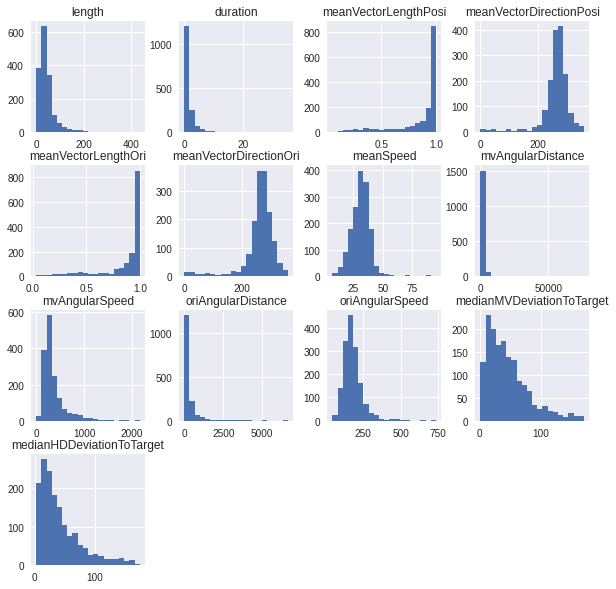

In [49]:
dfHome.hist(bins=20,figsize=(12,12))


array([[<AxesSubplot:title={'center':'length'}>,
        <AxesSubplot:title={'center':'duration'}>,
        <AxesSubplot:title={'center':'meanVectorLengthPosi'}>,
        <AxesSubplot:title={'center':'meanVectorDirectionPosi'}>],
       [<AxesSubplot:title={'center':'meanVectorLengthOri'}>,
        <AxesSubplot:title={'center':'meanVectorDirectionOri'}>,
        <AxesSubplot:title={'center':'meanSpeed'}>,
        <AxesSubplot:title={'center':'mvAngularDistance'}>],
       [<AxesSubplot:title={'center':'mvAngularSpeed'}>,
        <AxesSubplot:title={'center':'oriAngularDistance'}>,
        <AxesSubplot:title={'center':'oriAngularSpeed'}>,
        <AxesSubplot:title={'center':'medianMVDeviationToTarget'}>],
       [<AxesSubplot:title={'center':'medianHDDeviationToTarget'}>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

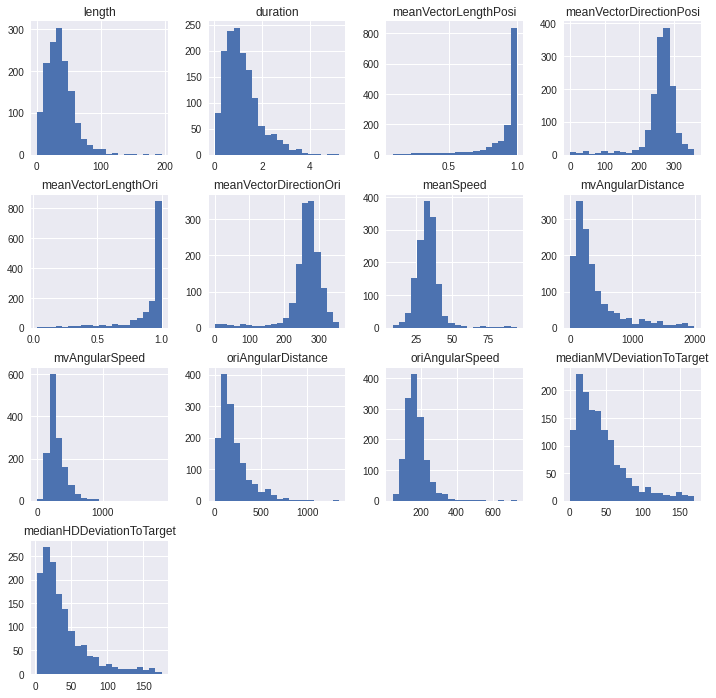

In [53]:
dfHome = dfHome[dfHome["mvAngularDistance"]<2000]
dfHome.hist(bins=20,figsize=(12,12))

In [54]:
import numpy as np
from sklearn.manifold import TSNE
X = dfHome.values
X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded.shape

(1436, 2)

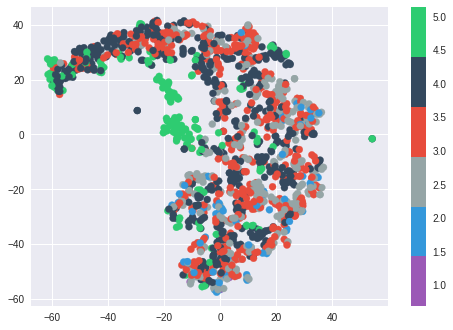

In [96]:
from matplotlib.colors import ListedColormap

flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
myCmap = ListedColormap(sns.color_palette(flatui).as_hex())
plt.scatter(X_embedded[:,0],
            X_embedded[:,1], c = np.log1p(dfHome["medianMVDeviationToTarget"]),
            cmap = myCmap)
plt.colorbar()

In [78]:
print(sns.color_palette())
sns.color_palette()

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.3333333333333333, 0.6588235294117647, 0.40784313725490196), (0.7686274509803922, 0.3058823529411765, 0.3215686274509804), (0.5058823529411764, 0.4470588235294118, 0.6980392156862745), (0.8, 0.7254901960784313, 0.4549019607843137), (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]


[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.6980392156862745),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [84]:
sns.color_palette()[0,1]

TypeError: list indices must be integers or slices, not tuple